1. Imports

In [9]:
# Cell 1: Imports

import kagglehub                  
import os 
import pandas as pd              
import numpy as np              
import torch                   
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import copy

torch.manual_seed(11)

2. Load Data and Preprocess

In [10]:
# Cell 2: Load and Preprocess Data

# 1. Request dataset
path = kagglehub.dataset_download("fedesoriano/body-fat-prediction-dataset")
csv_path = os.path.join(path, 'bodyfat.csv')

# 2. Load into Pandas
df = pd.read_csv(csv_path)
print("Data loaded. Original shape:", df.shape)

# New Feature
df['BMI'] = 703 * df['Weight'] / (df['Height'] ** 2)

# 3. Define Features (X) and Target (y)
X = df.drop(['BodyFat', 'Density'], axis=1).values
y = df['BodyFat'].values

# 4. Split into Training (80%) and Testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Standarize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Data processed successfully.")
print(f"Training Features shape: {X_train.shape}")
print(f"Testing Features shape: {X_test.shape}")

Data loaded. Original shape: (252, 15)
Data processed successfully.
Training Features shape: (201, 14)
Testing Features shape: (51, 14)


3) Create Tensors and Define Model

In [11]:
# Cell 3: Tensors and Model Definition

# 1. Convert Numpy arrays to PyTorch Tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
y_test_tensor = torch.FloatTensor(y_test).view(-1, 1)

# 2. Create DataLoaders (Batches)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True) 

# 3. Define the Neural Network Class
class BodyFatNN(nn.Module):
    def __init__(self, input_size):
        super(BodyFatNN, self).__init__()
        
        # Layer 1: 13 -> 64
        self.layer1 = nn.Linear(input_size, 64)
        self.dropout1 = nn.Dropout(0.3)
        
        # Layer 2: 64 -> 16
        self.layer2 = nn.Linear(64, 16)
        self.dropout2 = nn.Dropout(0.2)
        
        # Output: 16 -> 1
        self.output = nn.Linear(16, 1)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout1(x)
        
        x = self.relu(self.layer2(x))
        x = self.dropout2(x)
        
        x = self.output(x)
        return x

input_features = X_train.shape[1]
model = BodyFatNN(input_features)

4. Training Loop

In [12]:
# Cell 4: The Training Loop (Improved & Fixed)

# 1. Setup
criterion = nn.MSELoss()
# Weight Decay = L2 Regularization (Penalizes huge weights to prevent overfitting)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

epochs = 1000
best_test_loss = float('inf')
best_model_state = None

print("Training started...")

for epoch in range(epochs):
    # Training Phase
    model.train()
    train_loss = 0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validation Phase
    if (epoch+1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            test_pred = model(X_test_tensor)
            test_loss = criterion(test_pred, y_test_tensor).item()
            
            # Save the model IFF it beats the previous best score
            if test_loss < best_test_loss:
                best_test_loss = test_loss
                # deepcopy to save state
                best_model_state = copy.deepcopy(model.state_dict())

    # Print progress every 100 epochs
    if (epoch+1) % 100 == 0:
        avg_train_loss = train_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.4f} | Test Loss: {test_loss:.4f}')

# 2. Restore the Best Model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\nTraining Complete. Best model restored with Test Loss: {best_test_loss:.4f}")
else:
    print("\nTraining Complete. (No improvement found over initial random weights)")

Training started...
Epoch [100/1000] | Train Loss: 29.6908 | Test Loss: 22.7820
Epoch [200/1000] | Train Loss: 28.2942 | Test Loss: 21.7606
Epoch [300/1000] | Train Loss: 28.9738 | Test Loss: 22.4453
Epoch [400/1000] | Train Loss: 22.4956 | Test Loss: 23.7529
Epoch [500/1000] | Train Loss: 25.2369 | Test Loss: 24.2138
Epoch [600/1000] | Train Loss: 18.4318 | Test Loss: 27.5449
Epoch [700/1000] | Train Loss: 21.5566 | Test Loss: 28.6094
Epoch [800/1000] | Train Loss: 18.5228 | Test Loss: 29.2161
Epoch [900/1000] | Train Loss: 21.3408 | Test Loss: 30.1997
Epoch [1000/1000] | Train Loss: 18.1349 | Test Loss: 29.6523

Training Complete. Best model restored with Test Loss: 19.5049


5. Metric Evalution

In [ ]:
# Cell 5: Evaluation

# Change to eval mode
model.eval()

# Disable gradients in PyTorch
with torch.no_grad():
    # 1. Predict on the test set
    y_pred = model(X_test_tensor)
    
    # 2. Calculate Loss
    test_loss = criterion(y_pred, y_test_tensor)
    
    # 3. Calculate Mean Absolute Error (The average difference)
    mae = torch.mean(torch.abs(y_pred - y_test_tensor))

print(f"Final Test MSE: {test_loss.item():.4f}")
print(f"Average Error: {mae.item():.2f}% Body Fat")

print("\n Sample Predictions")
print("Actual  |  Predicted")
print("--------------------")
# Show the first 10 comparisons
for i in range(10):
    actual = y_test_tensor[i].item()
    pred = y_pred[i].item()
    print(f"{actual:.1f}%   |  {pred:.1f}%")

Final Test MSE: 19.5049
Average Error: 3.43% Body Fat

--- Sample Predictions ---
Actual  |  Predicted
--------------------
19.2%   |  16.3%
19.2%   |  15.6%
28.0%   |  29.2%
20.5%   |  15.8%
16.7%   |  13.6%
12.1%   |  15.5%
23.6%   |  14.6%
18.6%   |  21.0%
11.7%   |  11.5%
11.9%   |  22.6%


6. Visuals

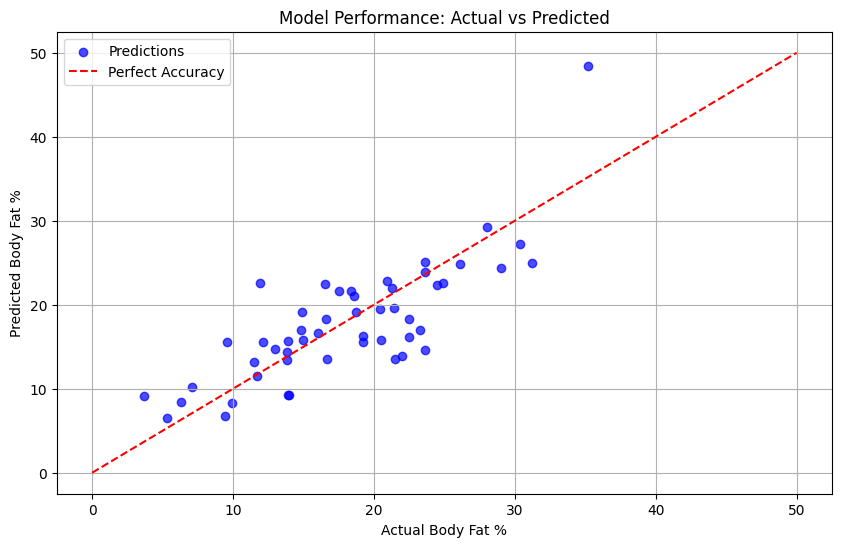

In [14]:
# Cell 6: Visualization

# 1. Get predictions for the whole test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy() # Convert back to Numpy for plotting
    y_actual = y_test_tensor.numpy()

# 2. Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(y_actual, y_pred, alpha=0.7, color='blue', label='Predictions')

# 3. Draw the "Perfect Prediction" line (Red dashed line)
# Values range from 0 to 50% body fat usually
plt.plot([0, 50], [0, 50], color='red', linestyle='--', label='Perfect Accuracy')

# 4. Labels and Title
plt.xlabel('Actual Body Fat %')
plt.ylabel('Predicted Body Fat %')
plt.title('Model Performance: Actual vs Predicted')
plt.legend()
plt.grid(True)

plt.show()

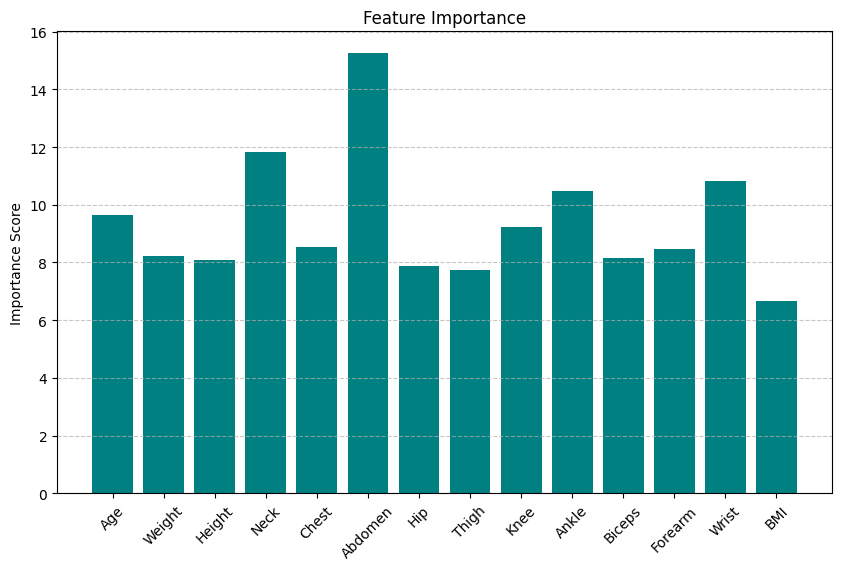

In [15]:
# Cell 7: Feature Importance Analysis (Fixed for BMI)
import matplotlib.pyplot as plt
import numpy as np

# 1. Get the weights
first_layer_weights = model.layer1.weight.data.numpy()
importance = np.sum(np.abs(first_layer_weights), axis=0)

# 2. Define names
feature_names = ['Age', 'Weight', 'Height', 'Neck', 'Chest', 'Abdomen', 
                 'Hip', 'Thigh', 'Knee', 'Ankle', 'Biceps', 'Forearm', 'Wrist', 'BMI']

# 3. Create the Bar Plot
plt.figure(figsize=(10, 6))
plt.bar(feature_names, importance, color='teal')
plt.xticks(rotation=45)
plt.title('Feature Importance')
plt.ylabel('Importance Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

7. Save Model

In [16]:
# Cell 9: Save the Model

# Save current state
torch.save(model.state_dict(), 'bodyfat_model.pth')
